## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

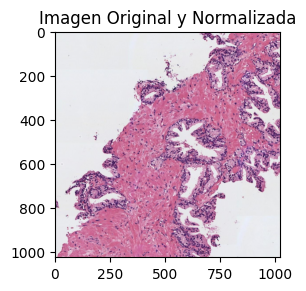

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('histo_1.jpg')

# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)##This function converts the  GBR Color frame from openCV to the standard RGB used in matplot and other libraries

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]

img_normalized = img_rgb.astype('uint8')/255  # OBV normalizamos dividendo entre el minimo y max valor posible* 0 a 255

# Visualizar la imagen
plt.subplot(1, 2, 1)
plt.imshow(img_normalized , cmap='gray') 
plt.title('Imagen Original y Normalizada')

## DATO INTERESANTE: plt.imshow es capaz de detectar cuando los pixeles de una imagene stán escalados entre 0 y 1 y escarlos de vuelta a esacla 0 a 255 de RGB (Por eso sale bien la imagen). 
## Si obviamente, exista un pixel con valor > 1 ya se fastidiaría esta propiedad de plt.imshow().

plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

Pequeño recordatorio:

C: Cian (Cyan): Representa el color azul-verdoso.

M: Magenta: Representa el color purpura-magenta.

Y: Amarillo (Yellow): Representa el color amarillo.

K: Negro (Key): Representa el color negro.

<Figure size 1200x800 with 0 Axes>

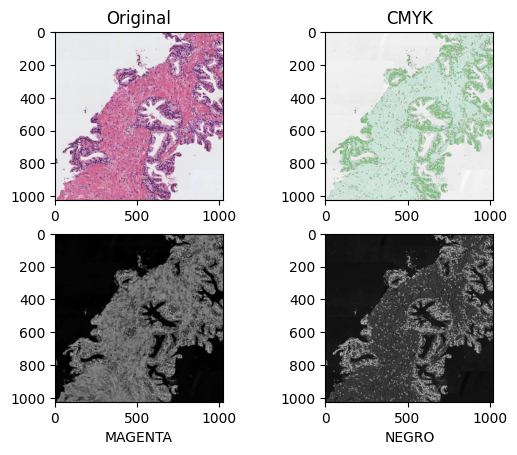

In [3]:
#Nota: La imagen ya está normalizada del apartado anterior
rgb_mg = img_normalized.copy()
#Transnformamos valores de pixeles.

#Como está dividido los pixeles un una imagen de OpenCV? 
#El primer índice (:) representa las filas de la imagen.
# El segundo índice (:) representa las columnas de la imagen.
# El tercer índice (0) representa los canales de color (0: R, 1: G, 2: B).


# UNa vez que sabemos esto podemos idnetificar extraer lo que queremos


with np.errstate(invalid='ignore', divide='ignore'): #El statement with ignora cuando ocurran errores de división o errores de invalidez.

    #Comentamos el código para entender mejor las transformaciones.

    # Calculate the K (Key/Black) channel by taking the maximum value along the color channels (axis=2)
    # and subtracting it from 1. This calculates the amount of black color needed for each pixel.
    K = 1 - np.max(rgb_mg, axis=2)

    # Calculate the C (Cyan) channel using the normalized red channel and the K channel.
    # It represents the amount of cyan color required for each pixel.
    C = (1 - rgb_mg[:,:,0] - K) / (1 - K)

    # Calculate the M (Magenta) channel using the normalized green channel and the K channel.
    # It represents the amount of magenta color required for each pixel.
    M = (1 - rgb_mg[:,:,1] - K) / (1 - K)

    # Calculate the Y (Yellow) channel using the normalized blue channel and the K channel.
    # It represents the amount of yellow color required for each pixel.
    Y = (1 - rgb_mg[:,:,2] - K) / (1 - K)

CMYK = (np.dstack((C,M,Y,K))*255).astype(np.uint8)
C,M,Y,K = cv2.split(CMYK)

# Extraer la componente magenta de la imagen (que corresponde a la región tisular) # Visualizar la imagen del canal magenta
plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(rgb_mg, cmap='gray'), ax[0, 0].set_title('Original')
ax[0, 1].imshow(CMYK.astype('uint8'), cmap='gray'), ax[0, 1].set_title('CMYK')
ax[1, 0].imshow(M.astype('uint8'), cmap='gray'), ax[1, 0].set_xlabel('MAGENTA')
ax[1, 1].imshow(K.astype('uint8'), cmap='gray'), ax[1, 1].set_xlabel('NEGRO') # Uncomment this line if you want to add another subplot in the third row
plt.show()




#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.<br><br>
Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".<br><br>
Visualizar la máscara resultante

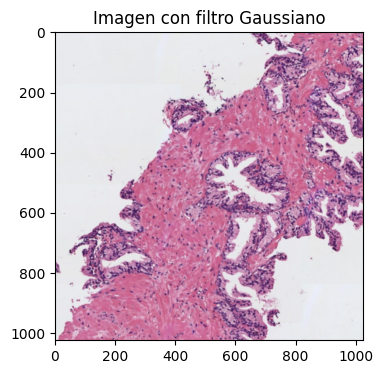

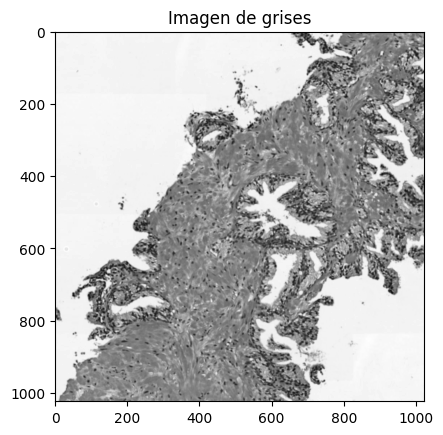

In [4]:
rgb_onsu= img_rgb.astype('uint8')
# Aplicamos un filtro gaussiano para emborronar las altas frecuencias

img_gauss = cv2.GaussianBlur(rgb_onsu, (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.figure(figsize=(6, 4)) 
plt.imshow(img_gauss, cmap='gray')
plt.title('Imagen con filtro Gaussiano')
plt.show()


gray_img_gauss = cv2.cvtColor(img_gauss, cv2.COLOR_BGR2GRAY)
#gray_img = cv2.imread('figuras.png', 0) # Una forma de leer la imagen directamente en escala de grises y quitar el formato RGB (Solo un canal)

plt.imshow(gray_img_gauss, cmap='gray')
plt.title('Imagen de grises')
plt.show()


[0 1]


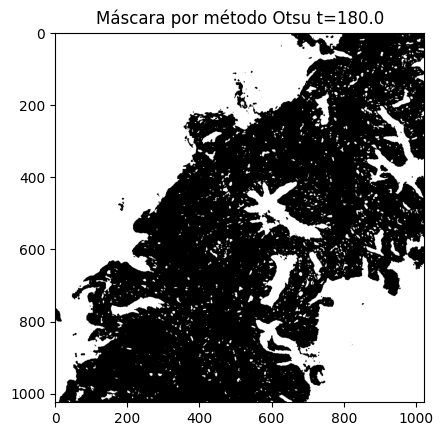

In [5]:
t, mask_ots = cv2.threshold(gray_img_gauss,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
print(np.unique(mask_ots))
# Utilizando el método de Otsu para fijar un umbral en una imagen en escala de grises (gray_img).
# El método busca el umbral óptimo (t) para separar los píxeles de primer plano y fondo.
# El resultado binarizado se almacena en la variable 'mask', donde 0 representa el fondo y 1 el primer plano.
# La función np.unique(mask) muestra los valores únicos en la máscara (0 y 1).
# La visualización con plt.imshow muestra la máscara binarizada en escala de grises.
# Asegúrate de importar las bibliotecas cv2 y matplotlib.pyplot y que 'gray_img' sea la imagen de entrada.
# Nota: El método de Otsu asume que la imagen es bimodal, con dos picos claros en su histograma de intensidad.

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(mask_ots, cmap='gray')
plt.title('Máscara por método Otsu t=' + str(t))
plt.show()

Extra: El alumno quiere comprobar como salen la imagen con distintos indices y viendo el histograma

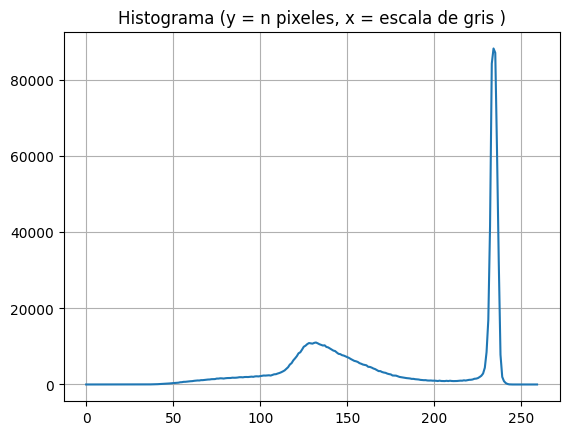

In [6]:
# Calculamos el histograma
hist = cv2.calcHist([gray_img_gauss], [0], None, [260], [0, 260]) # [0] son los canales, None la máscara

plt.plot(hist)
plt.grid()
plt.title('Histograma (y = n pixeles, x = escala de gris )')
plt.show()

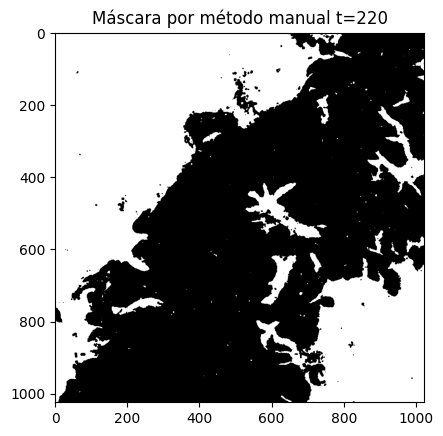

[  0 255]


In [7]:
# Fijamos el umbral en base al histograma anterior #Usamos el codigo único después de convertir a escala de girses, para definir la escala correcta binaria
t = 220

# Extreaemos la máscara binaria
maxim = 255
_, mask = cv2.threshold(gray_img_gauss, t, maxim, cv2.THRESH_BINARY)

# Otra formas de extraer la máscara 
# mask = gray_img.copy()
# mask = mask>t

# Visualizamos para corroborar
plt.imshow(mask, cmap='gray')
plt.title('Máscara por método manual t=' + str(t))
plt.show()

print(np.unique(mask)) # Atent@s a los formatos (bool, uint8, etc.)

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

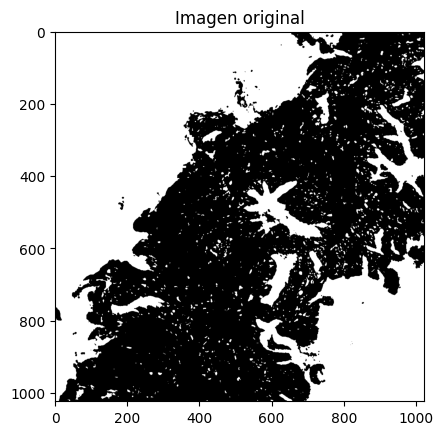

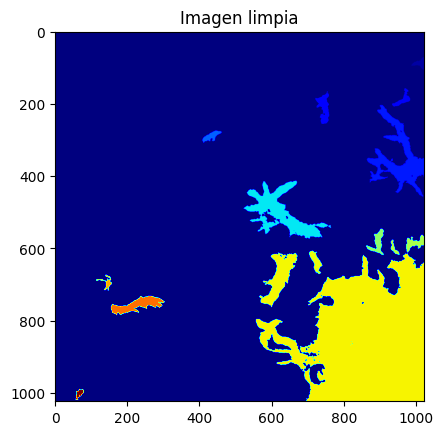

In [8]:
from skimage import morphology, measure
from skimage.measure import label
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
labeled_mask_ots = measure.label(mask_ots, connectivity=2)

min_object_area = 300
cleaned_img_rgb = morphology.remove_small_objects(labeled_mask_ots, min_size=min_object_area)

plt.imshow(mask_ots , cmap='gray')
plt.title('Imagen original')
plt.show()

plt.imshow(cleaned_img_rgb , cmap='jet' )
plt.title('Imagen limpia')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

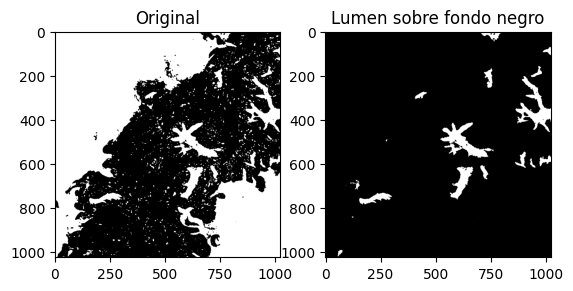

In [9]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

# Crear una copia de la imagen
mask_lumen = mask_ots.copy()

# Definir una imagen negra de referencia. se obtienen las dimensiones de la imagen original img. h representa la altura (número de filas) de la imagen, y w representa el ancho (número de columnas) de la imagen.
h, w = mask_ots.shape
ref = np.zeros((h+2, w+2), np.uint8) #### Metemos esa imagen. Aquí se está creando una nueva imagen llamada ref, que es una imagen completamente negra o en blanco (todos los píxeles tienen valor cero). 
# La imagen se crea con un tamaño ligeramente más grande que la imagen original. 
# Se agrega un borde de un píxel alrededor de la imagen original, y esto se hace aumentando las dimensiones de la imagen h+2 filas y w+2 columnas.
#  El tipo de datos np.uint8 se refiere a enteros sin signo de 8 bits, lo que significa que los valores de los píxeles van desde 0 a 255.
# La razón detrás de crear esta imagen negra de referencia (ref) con un borde más grande es que algunos algoritmos de procesamiento de imágenes, como ciertas operaciones de detección de bordes o algunas transformaciones morfológicas, pueden requerir espacio adicional alrededor de la imagen para realizar sus cálculos sin problemas y sin que se produzcan problemas de desbordamiento de memoria.
# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí

cv2.floodFill(mask_lumen, ref, (0,0), 0) # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(mask_lumen, ref, (1000,1000), 0) #Segunda semilla.

## Una buena forma de desarollar otro algoritmo para detectar los espacios blancos sería situar la semilla en las dos áreas más grandes (aunque se podría dar el caso que existan 3 areas por ciertos motivos, etc...)


# Definimos que es y que no es lumen por el tamaño de célula.
regions_to_keep = cleaned_img_rgb > 0

# Retiramos todo lo que no esté definido. #Nota: Con las técnicas que usamos, podemos perder algún lumen que este abierto al espacio blanco de fuera.
mask_lumen2 = np.zeros_like(mask_lumen)
mask_lumen2[regions_to_keep] = mask_lumen[regions_to_keep]



fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_ots, cmap='gray'), ax[0].set_title('Original')
ax[1].imshow(mask_lumen2, cmap='gray'), ax[1].set_title('Lumen sobre fondo negro')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

(<matplotlib.image.AxesImage at 0x12eae8557d0>,
 Text(0.5, 1.0, 'Lumen sobre fondo negro'))

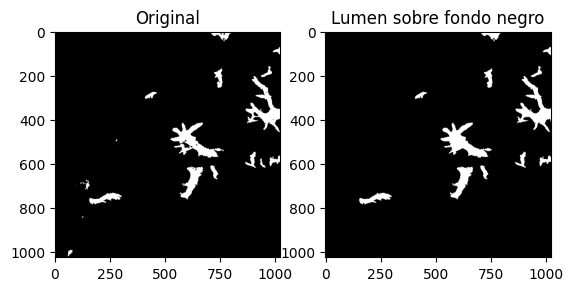

In [10]:
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology


#Usamos la última imagen procesada y limpiamos puntos negros dentro del lumen

lumen_clean = binary_fill_holes(mask_lumen2)

#Hacemos también una pequeña limpieza de area que se nos han colado en 300 y no son lumen
min_region_area = 500

lumen_clean  = morphology.remove_small_objects(lumen_clean , min_size=min_region_area)

# Visualizar la máscara resultante

fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_lumen2, cmap='gray'), ax[0].set_title('Original')
ax[1].imshow(lumen_clean, cmap='gray'), ax[1].set_title('Lumen sobre fondo negro')

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

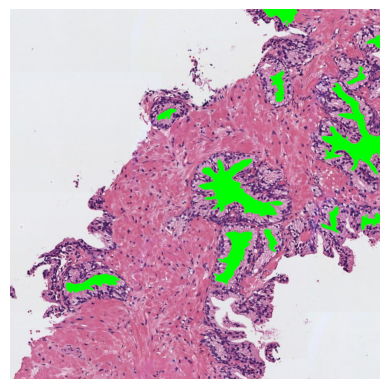

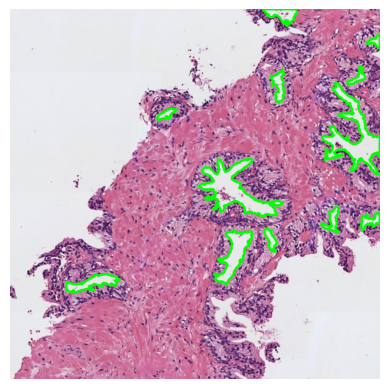

In [11]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 


# Encontrar los contornos en la máscara binaria
img_rgb_contornoslumen= img_rgb.copy()
img_rgb_contornoslumen[lumen_clean == 1] = [0, 255, 0] 

# Visualizar la imagen superpuesta
plt.imshow(img_rgb_contornoslumen)
plt.axis('off')  
plt.show()

#Si lo que queremos es una linea solo
img_rgb_contornoslumen2= img_rgb.copy()
# Encontrar los contornos en la imagen de contornos
imagen_contornos = lumen_clean.astype(np.uint8)
contornos, _ = cv2.findContours(imagen_contornos, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_rgb_contornoslumen2, contornos, -1, (0, 255, 0), 5)


# Mostrar la imagen resultante con los contornos resaltados con el grosor especificado
plt.imshow(img_rgb_contornoslumen2)
plt.axis('off')  # Desactivar ejes para una visualización limpia
plt.show()

#### 7) Identificar y cropear el lumen más grande

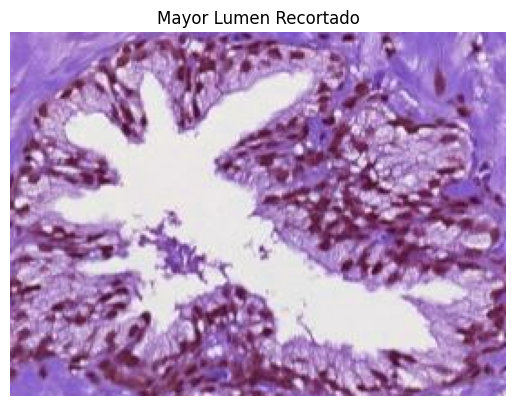

In [18]:
from skimage.measure import label, regionprops

# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.

## Identificamos el lumen de manera automática a partir de nuestra imagen de blancos y negros.


# Etiquetar los objetos en la imagen binaria
etiquetas = label(lumen_clean)

# Obtener las propiedades de los objetos etiquetados
propiedades = regionprops(etiquetas)

# Encontrar el objeto con el área más grande
area_maxima = 0
etiqueta_maxima = 0
for propiedad in propiedades:
    area = propiedad.area
    if area > area_maxima:
        area_maxima = area
        etiqueta_maxima = propiedad.label

# Obtener las coordenadas del cuadro delimitador del objeto más grande
coordenadas = propiedades[etiqueta_maxima - 1].bbox
y_min, x_min, y_max, x_max = coordenadas

# Recortar la región rectangular correspondiente de la imagen original
lumen_recortado = img_rgb[(y_min-20):(y_max+20), (x_min-20):(x_max+20)] ## Le damos un poquitín más de espaico con el -20 y +20

# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(lumen_recortado, cv2.COLOR_BGR2RGB))
plt.title('Mayor Lumen Recortado')
plt.axis('off')  # No mostrar ejes
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [33]:
from tabulate import tabulate
import math

# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.

# 1) Área

print(f"El área del objeto más grande es: {area_maxima} píxeles")

# 2) Área de la bounding box
# Calcular el ancho y alto del rectángulo
ancho = x_max - x_min
alto = y_max - y_min

# Calcular el área del rectángulo
area_rectangulo = ancho * alto

print(f"El área del rectángulo en el objeto más grande es: {area_rectangulo} píxeles")

# 3) Área convexa

# Obtener la envolvente convexa del objeto más grande usando la etiqueta
etiqueta_objeto_maximo = etiqueta_maxima
objeto_recortado = (etiquetas == etiqueta_objeto_maximo).astype(np.uint8)
contornos, _ = cv2.findContours(objeto_recortado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
envolvente_convexa = cv2.convexHull(contornos[0])

# Calcular el área de la envolvente convexa
area_envolvente_convexa = cv2.contourArea(envolvente_convexa)

print(f"El área de la envolvente convexa del objeto más grande es: {area_envolvente_convexa} píxeles")

# 4) Exentricidad


# Calcular el ajuste de elipse del objeto más grande
elipse = cv2.fitEllipse(envolvente_convexa)

# Calcular la excentricidad del objeto más grande
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

## La manera rápida de resolverlo a partir de las tablas aprendidas en clase.
new_lab, new_num = label(lumen_clean, return_num=True)

# Extraemos las característicias geométricas
headers = ['','Mayor Lumen']
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']


objeto = new_lab == etiqueta_maxima
prop = regionprops(objeto.astype(np.uint8))

A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

print("")
print("")
print("Todas las características en formato tabular")
print("")
print(tabulate(my_data, headers=headers))

El área del objeto más grande es: 13388.0 píxeles
El área del rectángulo en el objeto más grande es: 37674 píxeles
El área de la envolvente convexa del objeto más grande es: 27168.5 píxeles


Todas las características en formato tabular

                  Mayor Lumen
--------------  -------------
area               13388
bbox_area          37674
convex_area        27468
eccentricity           0.8443
equiv_diameter       130.561
extent                 0.3554
major_axis           231.639
minor_axis           124.136
orientation            0.9969
perimeter           1163.63
solidity               0.4874
compactness            0.1243
rectangularity         0.3554
